In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError

In [2]:
# load the dataset
DDoS = pd.read_csv('/content/dataset_sdn.csv')
DDoS.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [3]:
DDoS.Protocol.unique()
DDoS['Protocol'] = DDoS['Protocol'].replace('TCP', '0')
DDoS['Protocol'] = DDoS['Protocol'].replace('UDP', '1')
DDoS['Protocol'] = DDoS['Protocol'].replace('ICMP', '2')
DDoS.Protocol.unique()

array(['1', '0', '2'], dtype=object)

In [4]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [5]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [6]:
DDoS.isnull().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [7]:
features = DDoS[['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow','Protocol' ,'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps']]
target = DDoS['label']

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [8]:
class AutoEncoder(Model):
  def __init__(self, output_units, code_size=16):
    super().__init__()
    self.encoder = Sequential([
      Dense(20, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(20, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='mse', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=200,
    batch_size=16,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/200
3179/3179 [==============================] - 22s 6ms/step - loss: 0.0259 - accuracy: 0.5299 - val_loss: 0.0192 - val_accuracy: 0.8130
Epoch 2/200
3179/3179 [==============================] - 11s 3ms/step - loss: 0.0159 - accuracy: 0.6814 - val_loss: 0.0172 - val_accuracy: 0.8311
Epoch 3/200
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0142 - accuracy: 0.6974 - val_loss: 0.0162 - val_accuracy: 0.8072
Epoch 4/200
3179/3179 [==============================] - 9s 3ms/step - loss: 0.0133 - accuracy: 0.7154 - val_loss: 0.0159 - val_accuracy: 0.8389
Epoch 5/200
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0128 - accuracy: 0.7487 - val_loss: 0.0156 - val_accuracy: 0.8515
Epoch 6/200
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0126 - accuracy: 0.7693 - val_loss: 0.0152 - val_accuracy: 0.8536
Epoch 7/200
3179/3179 [==============================] - 15s 5ms/step - loss: 0.0124 - accuracy: 0.7659 - val_loss: 0.0152 - 

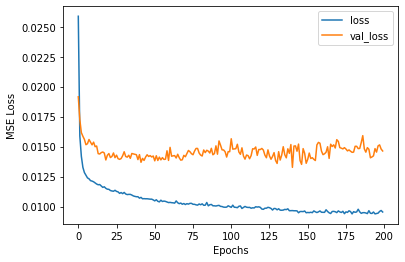

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [10]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

Threshold: 0.007815301966076106


In [11]:
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(y_test,predictions)

0.6827830753749581

In [12]:
!pip install -U keras-tuner

     |████████████████████████████████| 98 kB 5.7 MB/s 


In [16]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 19)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=16,
    validation_data=(x_test_scaled, x_test_scaled)
)

Trial 31 Complete [00h 03m 17s]
val_loss: 0.011004282161593437

Best val_loss So Far: 0.004620804451406002
Total elapsed time: 00h 42m 39s
INFO:tensorflow:Oracle triggered exit


In [18]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 52
dense_2_units: 48
dense_3_units: 44
dense_4_units: 52
dense_5_units: 36
dense_6_units: 72
learning_rate: 0.001


In [19]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=16,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 2/100
3179/3179 [==============================] - 9s 3ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 3/100
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 4/100
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 5/100
3179/3179 [==============================] - 12s 4ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 6/100
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 7/100
3179/3179 [==============================] - 9s 3ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 8/100
3179/3179 [==============================] - 11s 3ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 9/100
3179/3179 [==============================] - 10s 3ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 10/100
3179/3179 [==============================] - 9s 3ms/s

In [20]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)

0.7139297522641238